# Analisis exploratorio: Tweets Estatos Unidos



## Importación de librerías

In [406]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors

## Lectura de datos

In [407]:
tweets = pd.read_csv("train.csv")

In [408]:
tweets=tweets.drop_duplicates()
tweets

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


Hay 7613 registros

## El porqué de este análisis

Observemos detenidamente la ubicación de los tweets de nuestro set de datos:

In [409]:
tweets['location'].value_counts().head(20)

USA                104
New York            71
United States       50
London              45
Canada              29
Nigeria             28
UK                  27
Los Angeles, CA     26
India               24
Mumbai              22
Washington, DC      21
Kenya               20
Worldwide           19
Australia           18
Chicago, IL         18
California          17
New York, NY        15
California, USA     15
Everywhere          15
Florida             14
Name: location, dtype: int64

Notamos que para un gran porcentje de tweets la ubicación conocida es o bien su país de procedencia, siendo este Estados Unidos, o bien un estado o ciudad  ubicados dentro del territorio estadounidense

## Acomodando nuestros datos

La información con la que contamos en la columna location de nuestro set de datos es muy variada. En algunos casos conocemos la ciudad de origen del tweet, en otros conocemos el estado o provincia , en otros el país y en otros información extraña que no se corresponde con ninguna ubicación. En esta sección acomodaremos el set de datos para contar con toda la información necesaria para poder hacer un análisis exaustivo de la emision de tweets en el país Estados Unidos

En principio veamos si tenemos registros que contengan datos nulos en la columna location

In [410]:
tweets['location'].isnull().value_counts()

False    5080
True     2533
Name: location, dtype: int64

Se observa que 2533 registros contienen datos nulos en esta columna. Estos registros no serán de utilidad para el
objetivo de este análisis por lo que serán descartados

In [411]:
tweets.drop(tweets[tweets.location.isnull()].index, inplace = True)

De los 7613 registros que teniamos inicialmente, quedaron 5080

Agrego al dataframe dos columnas:1.Columna **located:** contendrá la ubicación detectada 2.Columna **location_type:**  me servirá para saber el tipo de ubicación, es decir si corresponde al pais(P), al estado(E) o a la ciudad(C) 

In [412]:
tweets['located']="-"
tweets['location_type']="-"

Se comenzará con el proceso de detección de ubicaciones relacionadas a Estados Unidos. Se irá de lo más específico a 
lo más global(ciudad->estado->pais) con el objetivo de no perder información en el camino.

Para ayudarnos en el análisis vamos a utilizar un archivo csv el cual contiene todos los estados y ciudades de Estados unidos

In [413]:
archivo = pd.read_csv('archivo.csv')
archivo.dropna(inplace=True)
archivo.head(5)

,City,State
0,Abilene,Texas
1,Akron,Ohio
2,Albuquerque,New Mexico
3,Alexandria,Virginia
4,Allentown,Pennsylvania


**OBSERVACIÓN IMPORTANTE**


OBS1: **New York** es nombre tanto de ciudad como de estado. Los registros que se correspondan con este string serán considerados que pertenecen a la ciudad de Nueva York y seran considerados tambien cuando se haga referencia a dicho estado.

In [414]:
def detectar_iguales(ciudad):
    estados=archivo['State'].drop_duplicates().tolist()
    if str(ciudad) in estados:
        return ciudad
    return None

archivo['City'].transform(detectar_iguales).value_counts()


New York    1
Name: City, dtype: int64

### Paso 1: Detectar ciudad

En primer lugar vamos detectar todos aquellos registros cuya ubicación contenga el nombre de alguna ciudad de Estados Unidos. Con este objetivo se define la siguiente función:

In [415]:
def detectar_ciudades(x):
    cities = archivo['City'].tolist()
    for city in cities:
        if city.upper() in str(x).upper():
            return city
    return "-"

In [416]:
resultado = tweets[tweets['located']=="-"]['location'].transform(detectar_ciudades)
for indice in resultado.index.tolist():
    detection= resultado.loc[indice]
    if detection!='-':
        tweets.loc[indice,'located']= detection
        tweets.loc[indice,'location_type']='C'

In [417]:
tweets['location_type'].value_counts()

-    3987
C    1093
Name: location_type, dtype: int64

Hasta el momento tenemos detectada la procedencia de 1093 registros provenientes de Estados Unidos.

### Paso 2: Detectar Estados

Vamos a investigar los registros que aún  fueron localizados. La intención es detectar todos aquellos registros cuya ubicación contenga un Estado de Estados Unidos.

Definamos una función que me permita detectar si un string coincide con el nombre de un estado de Estados Unidos.


In [418]:
def detectar_estados(x):
    """indica si una cadena es exactamente igual al nombre de un estado de Estados Unidos"""
    estados=archivo['State'].drop_duplicates().tolist()
    
    for estado in estados:
        if estado.upper() in str(x).upper():
            return estado
    return "-"

In [419]:
resultado = tweets[tweets['located']=='-']['location'].transform(detectar_estados)
for indice in resultado.index.tolist():
    detection= resultado.loc[indice]
    if detection!='-':
        tweets.loc[indice,'located']= detection
        tweets.loc[indice,'location_type']='E'

In [420]:
tweets['location_type'].value_counts()

-    3527
C    1093
E     460
Name: location_type, dtype: int64

Hasta el momento se han localizado 1553 registros

### Paso 3: Detectar país

Solo nos queda detectar todos aquellos registros que contienen explicitamente el nombre del pais en Estados Unidos en
cualquiera de sus variantes

Se crea entonces una función que será la encargada de hacer las comparaciones:

In [421]:
def reconocer_United_States(x):
    "Indica si una cadena contiene la palabra estados unidos en alguna de sus variantes"
    posibilidades=['UNITED STATES','USA','US','U.S.A','EE.UU.','EEUU','EE UU','ESTADOS UNIDOS','840']
    for posibilidad in posibilidades:
        if posibilidad.upper() == str(x).upper():
            return 'United States'
    return "-"

In [422]:
resultado=tweets[tweets['located']=='-']['location'].transform(reconocer_United_States)
for indice in resultado.index.tolist():
    detection= resultado.loc[indice]
    if detection!='-':
        tweets.loc[indice,'located']= detection
        tweets.loc[indice,'location_type']='P'

In [423]:
tweets['location_type'].value_counts()

-    3358
C    1093
E     460
P     169
Name: location_type, dtype: int64

Se detectaron 169 registros contienen como ubicación alguna referencia a Estados Unidos.
Total detectados: 1722


### Paso 4: agregamos algunos manualmente

Se revisan algunos casos particulares

Se observa  algunos registros que no fueron detectados, podemos agregarlos a mano

In [424]:
lista1=['NYC','NY','Brooklyn, NY']
indices= tweets[tweets['location'].isin(lista1)].index.tolist()
for indice in indices:
    tweets.loc[indice,'located']='New York'
    tweets.loc[indice,'location_type']='C'
indices=tweets[tweets['location']=="Haddonfield, NJ"].index.tolist()
for indice in indices:
    tweets.loc[indice,'located']='New Jersey'
    tweets.loc[indice,'location_type']='E'

In [425]:
tweets['location_type'].value_counts()

-    3331
C    1116
E     464
P     169
Name: location_type, dtype: int64

**RESULTADO FINAL: 1749 REGISTROS LOCALIZADOS**

Luego de limpiar los datos, hechemos un vistazo a como quedó el set de datos con el que estaremos trabajando en nuestro
análisis exploratorio

In [426]:
datos=tweets[tweets['location_type']!="-"].copy()
datos

,id,keyword,location,text,target,located,location_type
31,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,Birmingham,C
34,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,Philadelphia,C
46,66,ablaze,"GREENSBORO,NORTH CAROLINA",How the West was burned: Thousands of wildfire...,1,Greensboro,C
50,73,ablaze,"Sheffield Township, Ohio",Deputies: Man shot before Brighton home set ab...,1,Ohio,E
53,77,ablaze,Anaheim,Police: Arsonist Deliberately Set Black Church...,1,Anaheim,C
...,...,...,...,...,...,...,...
7566,10815,wrecked,United States,http://t.co/qVx0VQTPz0 Cramer: Iger's 3 words ...,0,United States,P
7570,10821,wrecked,California,Cramer: Iger's 3 words that wrecked Disney's s...,0,California,E
7573,10824,wrecked,"Denton, Texas",Had an awesome time gettin wrecked at bowling ...,0,Denton,C
7579,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,Vancouver,C


## Análisis exploratorio

Ya limpio nuestro set de datos iniciaremos un análisis sobre la veracidad de los tweets sobre desastres emitidos desde Estados Unidos. La idea es analizar la veracidad de los tweet a nivel país e intentar identificar fuentes de tweets falsos dentro del territorio estadounidense. Por otra parte se intentará descifrar si hay alguna relación entre la longitud de los tweet y su contenido con la veracidad o la falsedad de los mismos. Dividiremos el análisis en varias categorías. Para cada una de ellas se irá desde un análisis más global en el que se observará el comportamiento a nivel país hasa llegar a analizar algunos estados y ciudades cuya información llame la atención a la hora de hacer el análisis

### CANTIDAD

**Nivel pais**

Veamos a nivel país si tenemos más tweets falsos o más tweets verdaderos. Recordemos que para cada registro la columna target puede contener unicamente dos valores:
**0: tweet falso** o **1:tweet verdadero**

In [427]:
resultado = datos['target'].value_counts()
print("tweets totales: " + str(len(datos)))
resultado

tweets totales: 1749


0    962
1    787
Name: target, dtype: int64

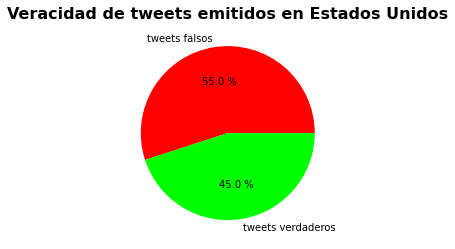

In [428]:
colores = ['red','lime']
plt.title('Veracidad de tweets emitidos en Estados Unidos',fontsize=16,fontweight='bold')
plt.pie(resultado, labels=['tweets falsos','tweets verdaderos'],autopct="%0.1f %%",colors = colores,)
plt.show()

Si bien se observa una mayor cantidad de tweets falsos, la diferencia  es tan solo de un 5%.

**Nivel Estados**

Pasemos ahora a analizar la veracidad de los tweets por estados. Veamos si encontramos algún estado en donde o bien la diferencia porcentual eneocntrada a nivel país se agrende o bien se invierta la tendencia y detectemos que la cantidad de tweets verdaderos supera a los falsos. 

Seleccionemos aquellos tweets para los que tenemos información sobre su estado 

In [429]:
seleccion1= tweets[tweets['location_type']=='E']
seleccion1=seleccion1.rename(columns={'located':'State'})
seleccion1.head(5)

,id,keyword,location,text,target,State,location_type
50,73,ablaze,"Sheffield Township, Ohio",Deputies: Man shot before Brighton home set ab...,1,Ohio,E
72,104,accident,"Walker County, Alabama",Reported motor vehicle accident in Curry on He...,1,Alabama,E
74,107,accident,North Carolina,I-77 Mile Marker 31 South Mooresville Iredell...,1,North Carolina,E
78,113,accident,North Carolina,I-77 Mile Marker 31 to 40 South Mooresville I...,1,North Carolina,E
94,136,accident,Alberta | Sask. | Montana,Suffield Alberta Accident https://t.co/bPTmlF4P10,1,Montana,E


Seleccionemos ahora aquellos tweets para los que conocemos su ciudad pero a priori no su estado y obtengamos el estado desde el archivo que utilizamos anteriormente

In [430]:
seleccion2=tweets[tweets['location_type']=='C'].merge(archivo,left_on='located',right_on='City',how='left')
seleccion2['located']=seleccion2['State']
seleccion2=seleccion2.drop(columns=['State'])
seleccion2=seleccion2.rename(columns={'located':'State'})
seleccion2.head(5)

,id,keyword,location,text,target,State,location_type,City
0,48,ablaze,Birmingham,@bbcmtd Wholesale Markets ablaze http://t.co/l...,1,Alabama,C,Birmingham
1,52,ablaze,"Philadelphia, PA",Crying out for more! Set me ablaze,0,Pennsylvania,C,Philadelphia
2,66,ablaze,"GREENSBORO,NORTH CAROLINA",How the West was burned: Thousands of wildfire...,1,North Carolina,C,Greensboro
3,77,ablaze,Anaheim,Police: Arsonist Deliberately Set Black Church...,1,California,C,Anaheim
4,82,ablaze,hollywoodland,They sky was ablaze tonight in Los Angeles. I'...,0,Florida,C,Hollywood


Combinanado ambas selecciones en una unica tabla

In [431]:
seleccionados=pd.concat([seleccion1,seleccion2])
seleccionados

,id,keyword,location,text,target,State,location_type,City
50,73,ablaze,"Sheffield Township, Ohio",Deputies: Man shot before Brighton home set ab...,1,Ohio,E,NaN
72,104,accident,"Walker County, Alabama",Reported motor vehicle accident in Curry on He...,1,Alabama,E,NaN
74,107,accident,North Carolina,I-77 Mile Marker 31 South Mooresville Iredell...,1,North Carolina,E,NaN
78,113,accident,North Carolina,I-77 Mile Marker 31 to 40 South Mooresville I...,1,North Carolina,E,NaN
94,136,accident,Alberta | Sask. | Montana,Suffield Alberta Accident https://t.co/bPTmlF4P10,1,Montana,E,NaN
...,...,...,...,...,...,...,...,...
1111,10785,wrecked,"Brooklyn, NY",Wrecked an hour on YouTube with @julian_lage @...,0,New York,C,New York
1112,10800,wrecked,Milwaukee County,http://t.co/DeQQOpSP4f: Iger's 3 words that wr...,0,Wisconsin,C,Milwaukee
1113,10824,wrecked,"Denton, Texas",Had an awesome time gettin wrecked at bowling ...,0,Texas,C,Denton
1114,10831,wrecked,"Vancouver, Canada",Three days off from work and they've pretty mu...,0,Washington,C,Vancouver


Calculamos la cantidad de tweets falsos y verdaderos por estado

In [527]:
cantidades = seleccionados.groupby('State').agg({'target':'value_counts'})
cantidades.columns =['cantidad']
cantidades.head(5)
#Ejemplo:

cantidad
State   target          
Alabama 1             17
        0             10
Alaska  1              4
        0              3
Arizona 1             15

Calculamos la diferencia entre la cantidad de tweets verdaderos y falsos (verdaderos - falsos). De esta forma en todos aquellos estados en donde haya más tweet verdaderos que verdaderos el resultado será negativo y será positivo en el caso contrario.

In [528]:
diferencias= cantidades.unstack().reset_index()
diferencias.columns=['State','0','1']
diferencias.fillna(0,inplace=True)
diferencias['dif']=diferencias['1']-diferencias['0']
diferencias.head(5)
#Ejemplo

,State,0,1,dif
0,Alabama,10.0,17.0,7.0
1,Alaska,3.0,4.0,1.0
2,Arizona,10.0,15.0,5.0
3,Arkansas,1.0,0.0,-1.0
4,California,147.0,131.0,-16.0


Hagamos ahora una visualización que nos permita apreciar los resultados obtenidos:

Carguemos un archivo shapefile del que extraeremos información para poder realizar los gráficos.

In [529]:
usa = gpd.read_file('shapefiles/USA_States.shp')
usa.drop(columns=['STATE_FIPS','STATE_ABBR'],inplace=True)
usa.head(5)

,STATE_NAME,geometry
0,Washington,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628..."
1,Montana,"POLYGON ((-111.47543 44.70216, -111.48080 44.6..."
2,Maine,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ..."
3,North Dakota,"POLYGON ((-98.73044 45.93827, -99.00683 45.939..."
4,South Dakota,"POLYGON ((-102.78838 42.99530, -103.00588 42.9..."


Añadimos nuestros resultados al archivo

In [530]:
usa= usa.merge(diferencias,how='left',right_on='State',left_on='STATE_NAME')
usa.drop(columns=['State'],inplace=True)
usa.fillna(0,inplace=True)
usa.head(5)

,STATE_NAME,geometry,0,1,dif
0,Washington,"MULTIPOLYGON (((-122.40202 48.22522, -122.4628...",66.0,61.0,-5.0
1,Montana,"POLYGON ((-111.47543 44.70216, -111.48080 44.6...",2.0,2.0,0.0
2,Maine,"MULTIPOLYGON (((-69.77728 44.07415, -69.85993 ...",0.0,0.0,0.0
3,North Dakota,"POLYGON ((-98.73044 45.93827, -99.00683 45.939...",0.0,1.0,1.0
4,South Dakota,"POLYGON ((-102.78838 42.99530, -103.00588 42.9...",1.0,2.0,1.0


Cantidad de tweets Falsos emitidos por estado

Cantidad de tweets Verdaderos emitidos por estado

Diferencia entre tweets verdaderos y falos

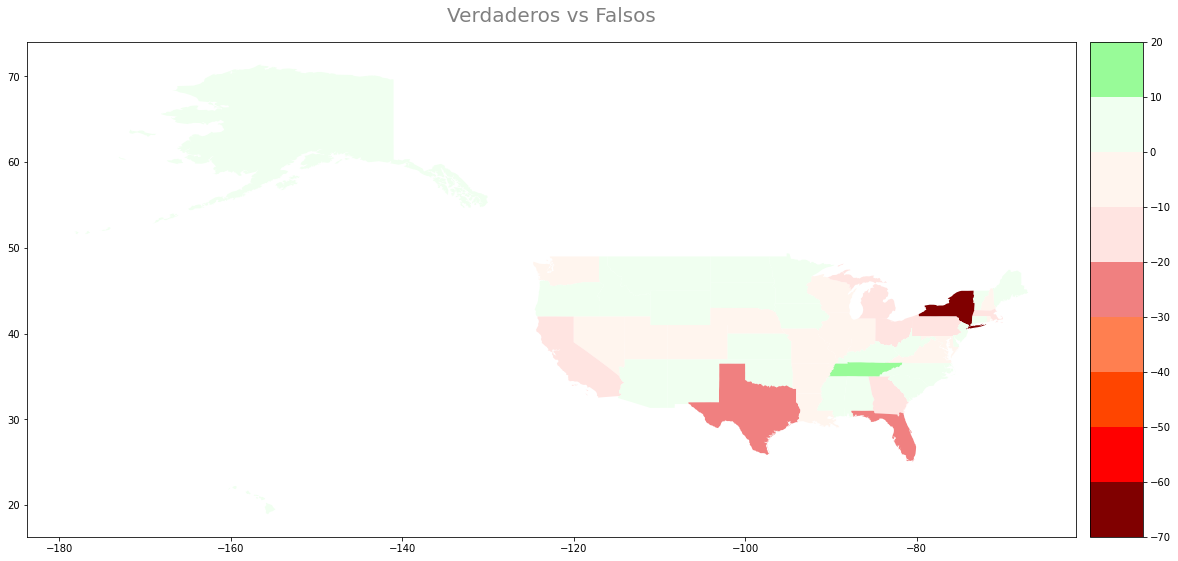

In [531]:
#Control del tamaño de la figura del mapa
fig, ax = plt.subplots(figsize=(20, 20))

# Control del título y los ejes
ax.set_title('Verdaderos vs Falsos', 
             pad = 20, 
             fontdict={'fontsize':20, 'color': 'Grey'})
 
# Añadir la leyenda separada del mapa
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.2) 

cmap = colors.ListedColormap(['maroon', 'red','orangered', 'coral', 'lightcoral','mistyrose','seashell','honeydew','palegreen'])
boundaries = [-70, -60, -50, -40, -30, -20,-10,0,10,20]
norm = colors.BoundaryNorm(boundaries, cmap.N, clip=True)

# Generar y cargar el mapa
usa.plot(column='dif', ax=ax,legend=True, cax=cax, zorder=5,cmap=cmap,norm=norm)


## LONGITUD

Un parámetro que puede resultar interesante es análizar si hay alguna relación entre la longitud de los tweets y la veracidad de los mismos.

In [447]:
datos['len']=datos['text'].transform(len)
datos_grouped= datos.groupby('target')
resultado=datos_grouped.agg({'len':['min','max','mean']})
level0= resultado.columns.get_level_values(0)
level1= resultado.columns.get_level_values(1)
resultado.columns= level0 + "_" + level1
resultado

,len_min,len_max,len_mean
target,,,
0,11,147,103.295218
1,30,143,108.614994


Se observa que los tweet verdaderos son en promedio más largos que los tweet falsos. Sin embargo tanto el tweet mas corto 
como más largo son falsos. 

In [388]:
# Calcular esperanza y varianza

***Keyword***

Cuando hablamos de keyword nos referimos a palabras clave que se mencionan en el tweet. No para todos los tweets conocemos información sobre dicha palabra. Filtremos aquellos tweets para los que si contamos con esta información